# Sharing numbers analysis

In [92]:
from __future__ import division, print_function
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.interpolate
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex

The analysis is largely based on the paper [].

For a given sequence $s$, $E(s) = -ln(p(s))$ is the Shannon surprise of generating a sequence $s$ at random. 

$g_{gen}(E)\  dE$ is the number of generated sequences whose surprise is between $E$ and $E + dE$. 

The density of states of the observed sequences will be written:
$$
    g(E) = g_{gen}\left(E - ln\left(\,f\,q\,\right)\right) \times f\,q
$$

Where $f$ is the proportion of functional sequences, in-frame, no stop codons or pseudogenes (for $\beta$, $0.236$ for humans), and $q$ is the selection factor that will be inferred from our data.

## Density of state of generated sequences 

IGoR commands:
```bash
N=10000000
CMD='./path/to/igor -set_wd "../Datas/IGoR_gen/" -batch beta'
$CMD -species human -chain beta -generate $N
$CMD -read_seqs "../Datas/IGoR_gen/beta_generated/generated_seqs_werr.csv"
$CMD -species human -chain beta -align --all
$CMD -species human -chain beta -evaluate -output --Pgen

CMD='./path/to/igor -set_wd "../Datas/IGoR_gen/" -batch alpha'
$CMD -species human -chain alpha -generate $N
$CMD -read_seqs "../Datas/IGoR_gen/alpha_generated/generated_seqs_werr.csv"
$CMD -species human -chain alpha -align --all
$CMD -species human -chain alpha -evaluate -output --Pgen
```

#### For $\beta$:

In [93]:
dE = 5e-1
df_gen = pd.read_csv("../Datas/IGoR_gen/beta_output/Pgen_counts.csv", sep=";")
df_gen["E"] = -np.log(df_gen["Pgen_estimate"])
maxE = max(df_gen.E)
Es = np.arange(0, maxE, dE)
p_gens, _ = np.histogram(df_gen["E"].values,
                                 bins=list(np.arange(0, maxE+dE, dE)))
normalisation = 1/(dE*np.sum(p_gens))
p_gens = normalisation * p_gens
g_gens = [pE*np.exp(E) for pE, E in zip(p_gens, Es)]

In [123]:
def M0(N, q, f, p_gen, maxE):
    dE = 5e-3
    return np.sum(
        [p_gen(E - np.log(f) - np.log(q))
         *np.exp(E)*(1-np.exp(-N*np.exp(-E)))*dE
         for E in np.arange(0, maxE+np.log(f)+np.log(q), dE)])

In [119]:
p_gen = scipy.interpolate.interp1d(np.arange(0,maxE,dE), p_gens)

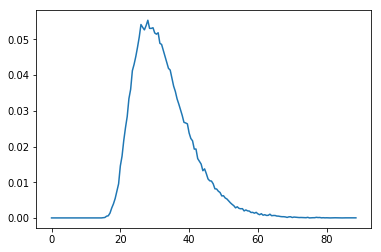

In [121]:
plt.plot(Es, p_gen(Es))
plt.show()

## Inferring the selection factor $q$

In [7]:
dfa = pd.read_csv("../Datas/exp3/sequences_alpha.tsv", sep="\t")
dfb = pd.read_csv("../Datas/exp3/sequences_beta.tsv", sep="\t")

In [151]:
dfb = dfb.dropna(subset=["amino"]) 
dfa = dfa.dropna(subset=["amino"]) 
print(len(dfb), " ", len(dfa))
dfb = dfb[dfb.status == "In"]

693906   1358381


In [154]:
nb_mean = 2
nb_unique_bb = []
nb_unique_nuc = []
for k in range(1, 100000, 10000):
    tot_a = tot_n = 0
    for i in range(nb_mean):
        df_sampled = dfb.sample(k)
        tot_n += len(np.unique(df_sampled.sequence))
        tot_a += len(np.unique(df_sampled.amino))
    nb_unique_bb.append(tot_a/nb_mean)
    nb_unique_nuc.append(tot_n/nb_mean)

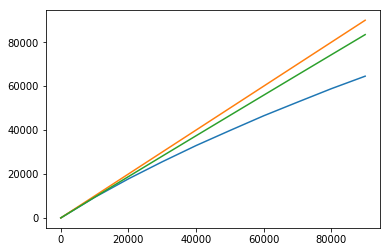

In [157]:
plt.plot(nb_unique_nuc, nb_unique_aa)
plt.plot(nb_unique_nuc,nb_unique_nuc)
Ns = range(0,100000,10000)
plt.plot(Ns,[M0(n,0.038,0.236,p_gen_beta,maxE) for n in Ns])
plt.show()